## 3.2 线性回归的实现

### 3.2.1 生成数据集

In [89]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"   #保证内核不崩

import matplotlib.pyplot as plt 
import torch
import random

def synthetic_data(w, b, num_examples): 
    """生成y=Xw+b+噪声"""
    X = torch.normal(0, 1, (num_examples, len(w))) 
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

print('features:',features[0],'\nlabel:',labels[0])


features: tensor([0.0536, 1.1570]) 
label: tensor([0.3666])


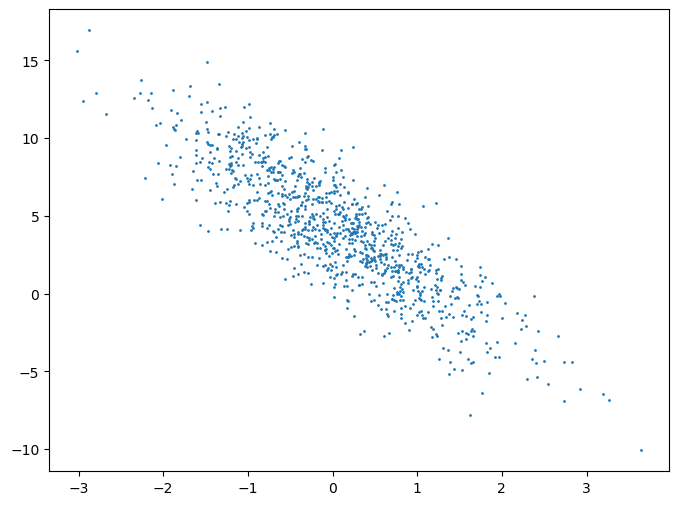

In [16]:
plt.figure(figsize=(8,6))
plt.scatter(features[:,1].detach().numpy(),labels.detach().numpy(),1)   #将某一列detach出来才能转换为numpy

### 3.2.2 读取数据集

In [17]:

def data_iter(batch_size, features, labels):    #data_iter 是生成器，每次循环只产生一个批次的数据
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)     #打乱顺序,这些样本是随机读取的，没有特定的顺序 
    for i in range(0, num_examples, batch_size):      
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]


In [34]:
#len()一个张量会返回第一个维度上的值
x=([[[0,1,3],
    [2,4,3]],
    [[5,6,3],
    [7,8,3]]])
print(x)
len(x)

[[[0, 1, 3], [2, 4, 3]], [[5, 6, 3], [7, 8, 3]]]


2

In [18]:
batch_size=10

for X,y in data_iter(batch_size,features,labels):
    print(X,'\n',y)
    break     


tensor([[-0.6296,  0.1784],
        [-0.2449,  0.2510],
        [ 0.4512,  1.2276],
        [ 0.6005,  0.1192],
        [-1.2973, -0.7088],
        [-0.7767,  1.1275],
        [ 1.3706, -1.0252],
        [-1.2520, -0.4068],
        [-0.1027, -0.4190],
        [ 0.2128, -0.8952]]) 
 tensor([[ 2.3474],
        [ 2.8513],
        [ 0.9143],
        [ 4.9839],
        [ 4.0101],
        [-1.1831],
        [10.4366],
        [ 3.0864],
        [ 5.4416],
        [ 7.6810]])


### 3.2.3 初始化模型参数

In [19]:
w=torch.normal(0,0.01,size=(2,1),requires_grad=True)
b=torch.zeros(1,requires_grad=True)

### 3.2.4 定义模型

In [20]:
def linreg(X,w,b):
    """线性回归模型"""
    return torch.matmul(X,w)+b

### 3.2.5定义损失函数

In [21]:
def squared_loss(y_hat,y):
    '''均方损失'''
    return(y_hat - y.reshape(y_hat.shape))**2/2

### 3.2.6 定义优化算法

In [22]:
def sgd(params, lr, batch_size):  
    """小批量随机梯度下降"""
    with torch.no_grad():    #torch.no_grad() 是一个上下文管理器，禁用梯度跟踪在参数更新时，我们不需要计算梯度，只需要执行数值计算,这样可以节省内存并提高性能
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

### 3.2.7 训练

In [23]:
lr=0.03
num_epochs=3
net=linreg
loss=squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y) # X和y的小批量损失
    # 因为l形状是(batch_size,1)，而不是一个标量。l中的所有元素被加到一起， 
    #  并以此计算关于[w,b]的梯度
        l.sum().backward()
        sgd([w, b], lr, batch_size) # 使用参数的梯度更新参数
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.045304
epoch 2, loss 0.000191
epoch 3, loss 0.000052


In [24]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}') 
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([ 1.1921e-06, -4.9734e-04], grad_fn=<SubBackward0>)
b的估计误差: tensor([0.0006], grad_fn=<RsubBackward1>)


## 3.3 线性回归的简洁实现

### 3.3.1生成数据集

In [25]:
import numpy as np
import torch 
from torch.utils import data

In [26]:
true_w=torch.tensor([2,-3.4])
true_b=4.2
features,labels=synthetic_data(true_w,true_b,1000)

### 3.3.2 读取数据集

In [27]:
def load_array(data_arrays, batch_size, is_train=True): 
    """构造一个PyTorch数据迭代器"""
    dataset = data.TensorDataset(*data_arrays)  
    #data.TensorDataset: PyTorch的数据集类，将多个张量组合成数据集;
    #*data_arrays: 解包操作，如果 data_arrays = (X, y)，则变成 TensorDataset(X, y);
    #创建的数据集对象可以按索引访问，如 dataset[i] 返回 (X[i], y[i])
    return data.DataLoader(dataset, batch_size, shuffle=is_train)
    #data.DataLoader: PyTorch的数据加载器，负责批量加载数据
    #shuffle=is_train: 训练时打乱数据，验证/测试时保持顺序

In [28]:
batch_size=10
data_iter=load_array((features,labels),batch_size)
next(iter(data_iter))   #构造迭代器并从中获取第一项

[tensor([[ 0.0100,  0.0408],
         [ 0.7747, -1.9427],
         [ 0.3860, -0.1407],
         [ 0.7485, -0.0888],
         [-0.1332,  1.1455],
         [-0.6962,  0.6478],
         [-0.4095, -1.8412],
         [-1.1160, -0.9539],
         [-0.0683, -0.0729],
         [ 0.1523, -0.1440]]),
 tensor([[ 4.0653],
         [12.3519],
         [ 5.4544],
         [ 5.9923],
         [ 0.0478],
         [ 0.6195],
         [ 9.6294],
         [ 5.2357],
         [ 4.3294],
         [ 4.9975]])]

### 3.3.3 定义模型

In [ ]:
# nn是神经网络的缩写
from torch import nn
net=nn.Sequential(nn.Linear(2,1))
#nn.Sequential一个容器，按顺序组合多个神经网络层数据会按照定义的顺序依次通过每一层;类似于一个管道，一层接一层处理数据
#nn.Linear(2, 1)线性层（全连接层）;2: 输入特征的维度,1: 输出特征的维度
#nn.Linear层的参数在创建时就默认设置了 requires_grad=True

### 3.3.4 初始化模型参数

In [30]:
net[0].weight.data.normal_(0, 0.01)
# net[0]: 访问Sequential容器中的第一个层（索引0）
# .weight: 该层的权重参数
# .data: 获取权重张量的数据部分（不包含梯度信息）
# .normal_(0, 0.01): 使用正态分布初始化权重
net[0].bias.data.fill_(0)
# net[0].bias: 该层的偏置参数
# .data: 获取偏置张量的数据部分
# .fill_(0): 将所有偏置值设置为0

tensor([0.])

### 3.3.5 定义损失函数

In [31]:
#计算均方误差使用的是MSELoss类，也称为平方L_2 范数。默认情况下，它返回所有样本损失的平均值。
loss=nn.MSELoss()

### 3.3.6 定义优化算法


In [32]:
trainer=torch.optim.SGD(net.parameters(),lr=0.03)

### 3.3.7 训练

In [ ]:
num_epochs = 3
for epoch in range(num_epochs):
    for X, y in data_iter:
        l = loss(net(X) ,y)
        trainer.zero_grad()
        l.backward()
        trainer.step()    # 执行一次参数更新
    l = loss(net(features), labels)
    print(f'epoch {epoch + 1}, loss {l:f}')

epoch 1, loss 0.000154
epoch 2, loss 0.000100
epoch 3, loss 0.000100


In [34]:
w = net[0].weight.data
b = net[0].bias.data
print('w的估计误差:', true_w - w.reshape(true_w.shape)) 
print('b的估计误差:', true_b - b)

w的估计误差: tensor([9.1648e-04, 8.8215e-06])
b的估计误差: tensor([0.0001])


## 3.5 图像分类数据集


### 3.5.1 读取数据集

In [2]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"   #保证内核不崩

import matplotlib.pyplot as plt 
import torch 
import torchvision
from torch.utils import data
from torchvision import transforms


In [3]:
# 通过ToTensor实例将图像数据从PIL类型变换成32位浮点数格式，
# 并除以255使得所有像素的数值均在0～1之间
trans = transforms.ToTensor()
mnist_train = torchvision.datasets.FashionMNIST(
    root="../data", train=True, transform=trans, download=True)
mnist_test = torchvision.datasets.FashionMNIST(
    root="../data", train=False, transform=trans, download=True)


In [4]:
len(mnist_test),len(mnist_train)

(10000, 60000)

In [46]:
# mnist_train[0]      # 返回一个元组 (图像张量, 标签)
# mnist_train[0][0]   # 获取元组的第一个元素，即图像张量
# mnist_train[0][0].shape  # 获取图像张量的形状
zhangliang,biaoqian=mnist_train[0]
zhangliang.shape,biaoqian

(torch.Size([1, 28, 28]), 9)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 创建一个 5x5 的随机数组
data = np.random.rand(5, 5)

plt.imshow(data)
plt.colorbar()  # 显示颜色条
plt.title('二维数组作为图像显示')
plt.show()

In [ ]:
# 创建彩色图像数据 (高度, 宽度, 3个颜色通道)
import numpy as np
color_data = np.random.rand(10, 10, 3)

plt.imshow(color_data)
plt.title('彩色图像')
plt.axis('off')  # 隐藏坐标轴
plt.show()

In [6]:
def get_fashion_mnist_labels(labels): 
    """返回Fashion-MNIST数据集的文本标签"""
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
    'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

In [7]:
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5): 
    '''绘制图像列表'''
    figsize=((num_cols * scale, num_rows * scale))
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):    #zip(axes, imgs)：将两个列表配对；enumerate()：添加索引
        if torch.is_tensor(img): # 图片张量
            ax.imshow(img.numpy())   #将张量转换为图像
        else:
        # PIL图片
            ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)    #隐藏坐标轴
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

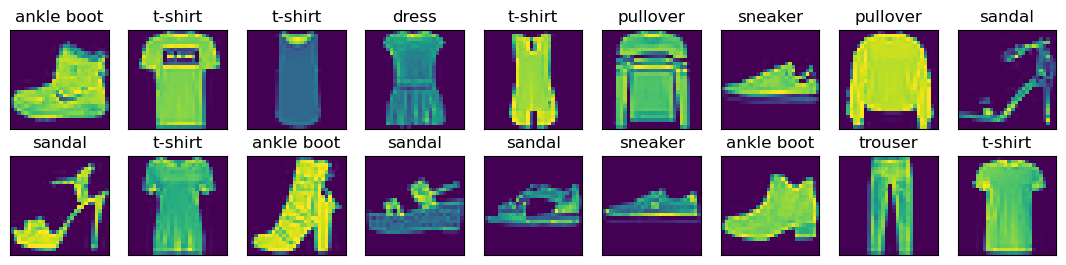

In [56]:
X,y=next(iter(data.DataLoader(mnist_train,batch_size=18)))
show_images(X.reshape(18,28,28),2,9,titles=get_fashion_mnist_labels(y));

### 3.5.2 读取小批量

In [ ]:
from random import shuffle


batch_size=256
def get_dataloader_workers():
    '''使用四个进程来读取'''
    return 4

train_iter=data.DataLoader(mnist_train,batch_size,shuffle=True,num_workers=get_dataloader_workers())
#torch.utils.data.DataLoader 是 PyTorch 中用于批量加载数据的重要工具

In [ ]:
import time
class Timer: 
    """记录多次运行时间"""
    def __init__(self):
        self.times = []
        self.start()
    def start(self):
        """启动计时器"""
        self.tik = time.time()  
    def stop(self):
        """停止计时器并将时间记录在列表中"""
        self.times.append(time.time() - self.tik)
        return self.times[-1]
    def avg(self):
        """返回平均时间"""
        return sum(self.times) / len(self.times)
    def sum(self):
        """返回时间总和"""
        return sum(self.times)
    def cumsum(self):
        """返回累计时间"""
        return np.array(self.times).cumsum().tolist()

In [59]:
timer=Timer()
for X, y in train_iter:    #快速遍历所有数据批次而不做任何实际工作的简洁写法
    continue
f'{timer.stop():.2f} sec'

'3.39 sec'

### 3.5.3 整合所有组件

In [ ]:
def load_data_fashion_mnist(batch_size, resize=None): 
    """下载Fashion-MNIST数据集，然后将其加载到内存中"""
    trans = [transforms.ToTensor()]
    # transforms.ToTensor(): 将 PIL 图像或 numpy 数组转换为 PyTorch 张量，并自动归一化到 [0,1]
    # transforms.Resize(resize): 如果指定了 resize 参数，调整图像大小
    # transforms.Compose(trans): 组织多个变换操作成一个流水线，便于复用相同的预处理流程
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(
        root="../data", train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(
        root="../data", train=False, transform=trans, download=True)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=get_dataloader_workers()),
            data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=get_dataloader_workers()))

In [ ]:
train_iter,test_iter=load_data_fashion_mnist(32,resize=64)
for X,y in train_iter:
    print(X.shape,X.dtype,y.shape,y.dtype)
    break
#X.shape中1是通道数

torch.Size([32, 1, 64, 64]) torch.float32 torch.Size([32]) torch.int64


## 3.6 softmax回归的从零开始实现

In [62]:
import torch
from IPython import display

In [63]:
batch_size=256
train_iter,test_iter=load_data_fashion_mnist(batch_size)

### 3.6.1初始化模型参数

In [64]:
num_inputs=784
num_outputs=10

W=torch.normal(0,0.01,size=(num_inputs,num_outputs),requires_grad=True)
b=torch.zeros(num_outputs,requires_grad=True)

### 3.6.2 定义softmax操作

In [65]:
#sum操作回顾
X=torch.tensor([[1.0,2.0,3.0],
                [4.0,5.0,6.0]])
X.sum(0,keepdim=True),X.sum(1,keepdim=True)

(tensor([[5., 7., 9.]]),
 tensor([[ 6.],
         [15.]]))

In [66]:
def softmax(X):
    X_exp=torch.exp(X)
    partition=X_exp.sum(1,keepdim=True)
    return X_exp/partition 

In [67]:
X=torch.normal(0,1,(2,5))
print(X)
X_prob=softmax(X)
X_prob,X_prob.sum(1)

tensor([[ 0.8283,  0.0579,  1.4700, -0.7045,  1.5641],
        [-1.5019,  0.3954, -2.0770,  2.5751,  0.1689]])


(tensor([[0.1765, 0.0817, 0.3353, 0.0381, 0.3684],
         [0.0138, 0.0919, 0.0078, 0.8132, 0.0733]]),
 tensor([1.0000, 1.0000]))

### 3.6.3 定义模型

In [68]:
def net(X):
    return softmax(torch.matmul(X.reshape((-1,W.shape[0])),W)+b)

### 3.6.4 定义损失函数

In [69]:
y=torch.tensor([0,2])
y_hat=torch.tensor([[0.1,0.3,0.6],[0.3,0.2,0.5]])
y_hat[[0,1],y]

tensor([0.1000, 0.5000])

In [70]:
def cross_entropy(y_hat,y):
    return -torch.log(y_hat[range(len(y_hat)),y])

cross_entropy(y_hat,y)

tensor([2.3026, 0.6931])

### 3.6.5 分类精度

In [71]:
def accuracy(y_hat, y): 
    """计算预测正确的数量"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
        # print(y_hat)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

In [72]:
accuracy(y_hat,y)/len(y)

0.5

In [73]:
class Accumulator: 
    """在n个变量上累加"""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)
        
    def __getitem__(self, idx):
        return self.data[idx]

In [74]:
def evaluate_accuracy(net, data_iter): 
    """计算在指定数据集上模型的精度"""
    if isinstance(net, torch.nn.Module):
            net.eval() # 将模型设置为评估模式
    metric = Accumulator(2) # 创建累加器，跟踪2个值：正确预测数、预测总数
    with torch.no_grad():
           for X, y in data_iter:
            metric.add(accuracy(net(X), y), y.numel())  # 累加：正确预测数，批次样本数
    return metric[0] / metric[1]

In [75]:
evaluate_accuracy(net,test_iter)

0.1133

### 3.6.6 训练


In [ ]:
def train_epoch_ch3(net, train_iter, loss, updater): 
    """训练模型一个迭代周期(定义见第3章)"""
    # 将模型设置为训练模式
    if isinstance(net, torch.nn.Module):
        net.train()
    # 训练损失总和、训练准确度总和、样本数
    metric = Accumulator(3)
    for X, y in train_iter:
        # 计算梯度并更新参数
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            # 使用PyTorch内置的优化器和损失函数
            updater.zero_grad()
            l.mean().backward()
            updater.step()
        else:
            # 使用定制的优化器和损失函数
            l.sum().backward()
            updater(X.shape[0])
        metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    # 返回训练损失和训练精度
    return metric[0] / metric[2], metric[1] / metric[2]

In [78]:
import matplotlib.pyplot as plt
from matplotlib_inline import backend_inline
def use_svg_display():
    # 设置Matplotlib使用SVG格式显示
    backend_inline.set_matplotlib_formats('svg')

def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """设置matplotlib的轴"""
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()



class Animator: 
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                ylim=None, xscale='linear', yscale='linear',
                fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                figsize=(3.5, 2.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        use_svg_display()
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 使用lambda函数捕获参数
        self.config_axes = lambda: set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):   
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

In [79]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater): 
    """训练模型(定义见第3章)"""
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc

In [80]:
lr=0.1

def updater(batch_size):
    return sgd([W,b],lr,batch_size)

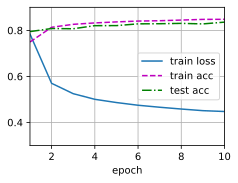

In [81]:
num_epochs=10
train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, updater)

### 3.6.7 预测

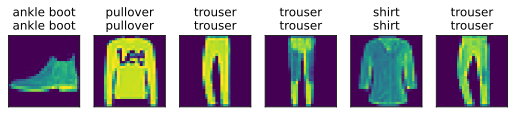

In [82]:
def predict_ch3(net, test_iter, n=6): 
    """预测标签(定义见第3章)"""
    for X, y in test_iter:
        break
    trues = get_fashion_mnist_labels(y)
    preds = get_fashion_mnist_labels(net(X).argmax(axis=1))
    titles = [true +'\n' + pred for true, pred in zip(trues, preds)]
    show_images(
        X[0:n].reshape((n, 28, 28)), 1, n, titles=titles[0:n])
    
predict_ch3(net, test_iter)

## 3.7 softmax 回归的简单实现

In [83]:
import torch
from torch import nn

In [84]:
batch_size=56
train_iter,test_iter=load_data_fashion_mnist(batch_size)

### 3.7.1 初始化参数模型 

In [ ]:
# PyTorch不会隐式地调整输入的形状。因此，
# 我们在线性层前定义了展平层（flatten），来调整网络输入的形状
net = nn.Sequential(nn.Flatten(), nn.Linear(784, 10))
# 检查模块类型是否为线性层 (nn.Linear)
# 如果是，用均值为0、标准差为0.01的正态分布初始化权重
# 偏置项(bias)保持默认初始化
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)
        
net.apply(init_weights);

### 3.7.2 重新审视softmax的实现



In [ ]:
loss=nn.CrossEntropyLoss(reduction='none')

#reduction='mean'：返回所有样本损失的平均值
#reduction='sum'：返回所有样本损失的总和
#reduction='none'：保留每个样本的独立损失值

### 3.7.3 优化算法

In [87]:
trainer=torch.optim.SGD(net.parameters(),lr=0.1)


### 3.7.4 训练

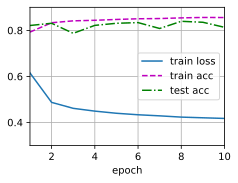

In [88]:
num_epochs=10
train_ch3(net,train_iter,test_iter,loss,num_epochs,trainer)